In [1]:
%matplotlib inline

from IPython.core.magic import register_line_magic
                                
import matplotlib.pyplot as plt

from annoy import AnnoyIndex
import torch.nn as nn

# from fastai.vision import ConvLearner 
from fastai import vision
import fastai
from torchsummary import summary

from PIL import Image
import requests

from tqdm import tqdm


from fastai import torch_core

import torchvision.models as tvm
from torch.utils.data import Dataset, DataLoader
import torch

import cv2
import glob
import numpy as np
import os

import torchvision
import torchvision.transforms as transforms

In [2]:
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Data Preparation
TODO: where should one download data or training images?

In [3]:
DATA_PATH = '../data/moma-artworks/'
DATA_TEST_PATH ='../data/moma-artworks-1000/'

In [4]:
from PIL import Image

In [18]:
base_transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
noisy_transform = transforms.RandomChoice([
    transforms.ColorJitter(brightness=0.5),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(saturation=0.2),
])

class NoisyImageDataset(object):
    def __init__(self, root_dir, transform=None, noisy_transform=None):
        # Look for jpegs in the directory
        self.image_paths = sorted(glob.glob(root_dir + '*.jpeg'))
        assert self.image_paths != 0, "No images found in {}".format(root_dir)

        self.image_names = [os.path.basename(path) for path in self.image_paths]
        self.transform = transform
        
        self.noisy_transofrm =  transforms.Compose([noisy_transform, self.transform])
        self.total_data = len(self.image_paths)

    def __len__(self):
        return self.total_data

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        
        image, x = self._load_and_transform(index)
        pos_x = self.noisy_transofrm(image)
        _, neg_x = self._load_and_transform(np.random.choice(self.total_data))
        
        return x, pos_x, neg_x
    def _load_and_transform(self, index):
        image_path = self.image_paths[index]
        
        # Returns image in RGB format; each pixel ranges between 0.0 and 1.0
        image = Image.open(image_path).convert('RGB')
        x = self.transform(image)
        return image, x
    
    def get(self, index):

        return self.__getitem__(index)
    
noisy_dataset = NoisyImageDataset(DATA_PATH, transform=base_transform, noisy_transform=noisy_transform)
trainloader = torch.utils.data.DataLoader(noisy_dataset, batch_size=32, shuffle=True, num_workers=2)

test_noisy_dataset = NoisyImageDataset(DATA_TEST_PATH, transform=base_transform, noisy_transform=noisy_transform)
testloader = torch.utils.data.DataLoader(test_noisy_dataset, batch_size=4, shuffle=False, num_workers=2)

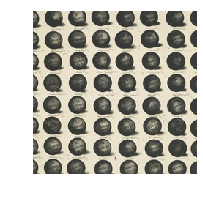

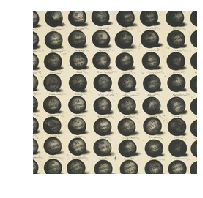

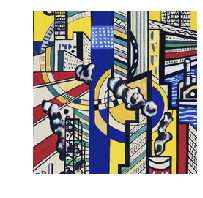

In [19]:
tx, tpx, tnx, = noisy_dataset.get(32)
vision.image.show_image(tx)
vision.image.show_image(tpx)
vision.image.show_image(tnx)

# AutoEncoder
image -> encoder -> z -> decoder -> image

In [12]:
import torch.nn.functional as F

import torch.nn as nn
from functools import reduce
import torch.optim as optim

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

# negative loss

In [32]:
def dist(x1, x2):
    return (x1 - x2).norm(p=2)

def negative_loss(x, pos_x, neg_x, gap=1):
     return torch.mean(dist(x, neg_x) + gap - dist(x, pos_x))

# Model 

In [76]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.model = tvm.vgg16(pretrained=True)
        self.features = self.model.features
        self.classifier = self.model.classifier[:4]

    def forward(self, batch):

        feature_output = self.features.forward(batch)
        feature_output = feature_output.view(feature_output.size(0), -1)

        return self.classifier.forward(feature_output)

In [77]:
VGG16()(torch.rand(7, 3, 244, 244)).shape

torch.Size([7, 4096])

In [78]:
class DVAE(nn.Module):
    def __init__(self, verbose=False):
        super(DVAE, self).__init__()
        self.vgg = VGG16()
        self.encoder = nn.Sequential(
            nn.Linear(4096, 1024), nn.ReLU(True),
        )
        

    def forward(self, x):
        x = self.vgg(x)
        z = self.encoder(x)
        norm = z.norm(p=2, dim=1, keepdim=True)
        normed_z = z.div(norm)

        return normed_z
    
    def parameters(self):
        return list(self.encoder.parameters()) 

In [ ]:
running_loss = []

dvae = DVAE()

optimizer = optim.Adam(dvae.parameters(), lr=0.001)

for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        
        optimizer.zero_grad()

        z = list(map(lambda x: dvae(x), data))

        loss = negative_loss(*z)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        if i % 5 == 0:    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, np.mean(running_loss)))
            running_loss = []

In [35]:
# image, pos_image, neg_image = noisy_dataset.get(500)

# imshow(torchvision.utils.make_grid(image))
# imshow(torchvision.utils.make_grid(pos_image))

# reconstructed_imgs, *_ = dvae(pos_image.view(1, 3, 224, 224))
# reconstructed_imgs = reconstructed_imgs.detach()

# imshow(torchvision.utils.make_grid(reconstructed_imgs))

ValueError: too many values to unpack (expected 2)

# .. 

In [138]:
# latent dim = 100
temp_net = nn.Sequential(
            nn.Conv2d(3, 25, 5), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(25, 20, 5), nn.ReLU(True),
            nn.ReLU(True),
            nn.MaxPool2d(4, 4),
            nn.Conv2d(20, 20, 5),
            nn.ReLU(True),
            nn.MaxPool2d(4, 4),
            Flatten(),
            nn.Linear(500, 256), nn.ReLU(True),
            nn.Linear(256, 128), 
)

temp_net(torch.rand(7, 3, 224, 224)).shape

torch.Size([7, 20, 5, 5])

In [160]:
temp_decoder = nn.Sequential(
    nn.Linear(100, 128), nn.ReLU(True),
    nn.Linear(128, 256), nn.ReLU(True),
    nn.Linear(256, 500), nn.ReLU(True),
    Reshape([20, 5, 5]),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(20, 20, 4), nn.ReLU(True),
    nn.Upsample(scale_factor=4),
    nn.ConvTranspose2d(20, 20, 5), nn.ReLU(True),
    nn.Upsample(scale_factor=4),
    nn.ConvTranspose2d(20, 1, 1), nn.Sigmoid()
#             
)
temp_decoder(torch.rand(7, 100)).shape

/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


torch.Size([7, 1, 224, 224])

In [214]:
len(testloader.dataset)

0

In [37]:
dvae.eval()
test_images = np.zeros((len(testloader.dataset), 128))
test_loss = []
with torch.no_grad():
    for i, data in enumerate(testloader):
        x = data[0]
        z = dvae(x)

        test_images[i*4:(i+1)*4] = z
        
#         test_loss.append(loss_function(x_hat, x, z_mu, z_logvar).item())

#     test_loss = np.mean(test_loss)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: nan


/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
test_images_normed = test_images / np.sqrt(np.sum(np.power(test_images, 2), axis=1)).reshape((-1, 1))

In [41]:
sim_matrix = test_images_normed.dot(test_images_normed.T)

In [42]:
nearest_neighbors = np.argsort(-sim_matrix, axis=1)

In [43]:
def find_similar_images(data_idx, nn=5):
    vision.image.show_image(testloader.dataset.get(data_idx)[0])

    axies = plt.subplots(1, nn, figsize=(2*nn,2))[1]
    similar_images = nearest_neighbors[data_idx, 1:(nn+1)]
    
    print('Visually similar images` indices : %s' % ','.join(map(str, similar_images)))
    
    for i, tt in enumerate(zip(axies, similar_images)):
        ax, idx = tt
        vision.image.show_image(testloader.dataset.get(idx)[0], ax=ax)

Visually similar images` indices : 1165,1901,3428,3431,4030


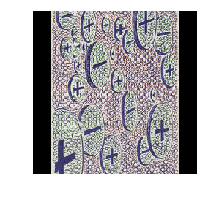

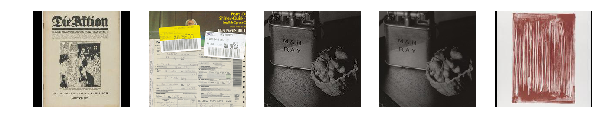

In [51]:
find_similar_images(55)

# compulte precision recall

In [59]:
def get_id(path):
    return path.split('/')[-1].split('.')[0]

def get_stats(k=3, max_rel_items=5, epsilon=np.finfo(float).eps):
    num_relevant_items = []
    for i, path in enumerate(testloader.dataset.image_paths):
        if '--m' in path:
            continue
    
        id_prefix = '%s--' % get_id(path)
        sims_path = map(lambda x: testloader.dataset.image_paths[x], nearest_neighbors[i, 1:(k+1)])
        sim_ids = list(filter(lambda s: id_prefix in get_id(s) , sims_path))

        num_relevant_items.append(float(len(sim_ids)))
    num_relevant_items = np.array(num_relevant_items)
    print('computing stats from %d items' % num_relevant_items.shape[0])
    precision = num_relevant_items / k
    recall = num_relevant_items / max_rel_items
    f1 = 2*((precision*recall)/(precision+recall+epsilon))
    
    print('Precision %.4f +/- %.4f' % (np.mean(precision), np.std(precision)))
    print('Recall    %.4f +/- %.4f' % (np.mean(recall), np.std(recall)))
    print('f1    %.4f +/- %.4f' % (np.mean(f1), np.std(f1)))
#     return (np.mean(precision), np.mean(recall), np.mean(f1)), (np.std(precision), np.std(recall), np.std(f1))

get_stats()

computing stats from 989 items
Precision 0.5730 +/- 0.3035
Recall    0.3438 +/- 0.1821
f1    0.4297 +/- 0.2276


In [ ]:
# experiment: First try with my loss 
# computing stats from 989 items
# Precision 0.5730 +/- 0.3035
# Recall    0.3438 +/- 0.1821
# f1    0.4297 +/- 0.2276
# In [ ]:


In [55]:
testloader.dataset.image_paths[:6]

['../data/moma-artworks-1000/100294--m1.jpeg',
 '../data/moma-artworks-1000/100294--m2.jpeg',
 '../data/moma-artworks-1000/100294--m3.jpeg',
 '../data/moma-artworks-1000/100294--m4.jpeg',
 '../data/moma-artworks-1000/100294--m5.jpeg',
 '../data/moma-artworks-1000/100294.jpeg']

In [71]:
raw_images = testloader.dataset.data.view(-1, 784).numpy()
raw_test_images_normed = raw_images / np.sqrt(np.sum(np.power(raw_images, 2), axis=1)).reshape((-1, 1))
raw_sim_matrix = raw_test_images_normed.dot(raw_test_images_normed.T)
raw_nearest_neighbors = np.argsort(-raw_sim_matrix, axis=1)
raw_first_nn = raw_nearest_neighbors[:, 1]
raw_predicted_labels = true_labels[raw_first_nn]
print('Predict from pixel values: accuracy %.4f' % np.mean(true_labels == raw_predicted_labels))

Predict from pixel values: accuracy 0.5373


(10000, 10000)

In [83]:
first_nn = nearest_neighbors[:, 1]

In [89]:
predicted_labels = true_labels[first_nn]

In [90]:
predicted_labels

array([5, 4, 1, 1, ..., 1, 8, 3, 5])

In [ ]:
print('accuracy %.4f' % np.mean(true_labels == predicted_labels))

In [ ]:
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, 5),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 15, 5),
            nn.BatchNorm2d(15),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(15 * 4 * 4, 120),
#             nn.Dropout(p=0.2),
            nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 120),
            nn.ReLU(True),
            nn.Linear(120, 15*4*4),
            nn.ReLU(True),
            Reshape([15, 4, 4]),
            nn.ConvTranspose2d(15, 20, 2),
            nn.BatchNorm2d(20),
            nn.ConvTranspose2d(20, 10, 4),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
            nn.ConvTranspose2d(10, 10, 4),
            nn.BatchNorm2d(10),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(10, 10, 5),
            nn.BatchNorm2d(10),
            nn.ConvTranspose2d(10, 1, 3),
            nn.Sigmoid()
        )

